In [3]:
sample_submission.shape, train_data.shape, test_data.shape

((31626, 2), (47439, 41), (31626, 40))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47439 entries, 0 to 47438
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  int64  
 1   Address                      47439 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      47089 non-null  object 
 4   Type                         47439 non-null  object 
 5   Year built                   46394 non-null  float64
 6   Heating                      40974 non-null  object 
 7   Cooling                      36817 non-null  object 
 8   Parking                      46531 non-null  object 
 9   Lot                          33258 non-null  float64
 10  Bedrooms                     44567 non-null  object 
 11  Bathrooms                    43974 non-null  float64
 12  Full bathrooms               39574 non-null  float64
 13  Total interior l

In [5]:
df_train=df.copy()
for field in ['Listed On', 'Last Sold On']:
    df_train[field]=pd.to_datetime(df[field])
    df_test[field]=pd.to_datetime(df_test[field])

In [6]:
cate_cols = []
num_cols = []
date_cols = []
dtypes = df_train.dtypes
for col, dtype in dtypes.items():
    if dtype=='object':
        cate_cols.append(col)
    elif dtype.name.startswith('datetime'):
        date_cols.append(col)
    else:
        num_cols.append(col)

In [7]:
id_col = 'Id'
target_col = 'Sold Price'

for col in [id_col, target_col]:
    num_cols.remove(col)
print(cate_cols)
print(num_cols)
print(date_cols)

['Address', 'Summary', 'Type', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Region', 'Elementary School', 'Middle School', 'High School', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'City', 'State']
['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Zip']
['Listed On', 'Last Sold On']


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from pandas.api.types import is_string_dtype, is_numeric_dtype

class Num_Features(BaseEstimator, TransformerMixin):
    def __init__(self, cols = [], fillna = False, addna = False):
        self.fillna = fillna
        self.cols = cols
        self.addna = addna
        self.na_cols = []
        self.imputers = {}
    def fit(self, X, y=None):
        for col in self.cols:
            if self.fillna:
                self.imputers[col] = X[col].median()
            if self.addna and X[col].isnull().sum():
                self.na_cols.append(col)
        print(self.na_cols, self.imputers)
        return self
    def transform(self, X, y=None):
        df = X.loc[:, self.cols]
        for col in self.imputers:
            df[col].fillna(self.imputers[col], inplace=True)
        for col in self.na_cols:
            df[col+'_na'] = pd.isnull(df[col])
        return df

In [9]:
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy, fill_value):
        self.strategy = strategy
        self.fill_value = fill_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col, content in X.items():
            X[col].fillna(self.fill_value, inplace=True)
        return X

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('select_num', Num_Features(cols=num_cols, fillna='median', addna=True)),
])
X_num = num_pipeline.fit_transform(df_train)

['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price'] {'Year built': 1967.0, 'Lot': 6502.0, 'Bathrooms': 2.0, 'Full bathrooms': 2.0, 'Total interior livable area': 1566.0, 'Total spaces': 1.0, 'Garage spaces': 1.0, 'Elementary School Score': 6.0, 'Elementary School Distance': 0.5, 'Middle School Score': 5.0, 'Middle School Distance': 1.0, 'High School Score': 6.0, 'High School Distance': 1.3, 'Tax assessed value': 547524.0, 'Annual tax amount': 7129.0, 'Listed Price': 949000.0, 'Last Sold Price': 598000.0, 'Zip': 94114.0}


In [11]:
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,cols, max_n_cat=7, onehot_cols=[], orders={}):
        self.cols = cols
        self.onehot_cols=onehot_cols
        self.cats = {}
        self.max_n_cat = max_n_cat
        self.orders = orders
    def fit(self, X, y=None):
        df_cat =  X.loc[:, self.cols]
        for n,c in df_cat.items():
            df_cat[n].fillna('NAN', inplace=True)
            df_cat[n] = c.astype('category').cat.as_ordered()
            if n in self.orders:
                df_cat[n].cat.set_categories(self.orders[n], ordered=True, inplace=True)
            cats_count = len(df_cat[n].cat.categories)
            if cats_count<=2 or cats_count>self.max_n_cat:
                self.cats[n] = df_cat[n].cat.categories
                if n in self.onehot_cols:
                    self.onehot_cols.remove(n)
            elif n not in self.onehot_cols:
                self.onehot_cols.append(n)

        print(self.onehot_cols)
        return self
    def transform(self, df, y=None):
        X = df.loc[:, self.cols]
        for col in self.cats:
            X[col].fillna('NAN', inplace=True)
            X.loc[:,col] = pd.Categorical(X[col], categories=self.cats[col], ordered=True)
            X.loc[:,col] = X[col].cat.codes

#         for n,c in X.items():
#             if n in self.cats:
#                 X[n] = pd.Categorical(c, categories=self.cats[n], ordered=True)
#                 X[n] = X[n].cat.codes + 1
#             else:
#                 X[n] = c.astype('category').cat.as_ordered()
        if len(self.onehot_cols):
            df_1h = pd.get_dummies(X[self.onehot_cols], dummy_na=True)
            df_drop=X.drop(self.onehot_cols,axis=1)
            return pd.concat([df_drop, df_1h], axis=1)

        return X

In [12]:
cat_pipeline = Pipeline([
    ('cat_encoder', CatEncoder(cols=cate_cols))
])
X_cate = cat_pipeline.fit_transform(df_train)

[]


In [13]:
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    field = df[field_name]
    if prefix is None:
        prefix = re.sub('[Dd]ate$', '', field_name)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    # Pandas removed `dt.week` in v1.1.10
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
    mask = ~field.isna()
    df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,np.nan)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

In [14]:
import re
class Datepart(BaseEstimator, TransformerMixin):
    def __init__(self, cols, time=False):
        self.cols = cols
        self.time = time
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df_dates = X.loc[:, self.cols]
        for col in self.cols:
            add_datepart(df_dates, col, time=False)
        return df_dates
    
date_pipeline = Pipeline([
    ('datepart', Datepart(cols=date_cols)),
    ('imputer', Imputer(strategy="constant", fill_value=-1)),
])

In [15]:
X_date = date_pipeline.fit_transform(df_train)

In [16]:
y_train = np.log(df_train[target_col])
X_train = pd.concat([X_num, X_cate,X_date], axis=1)
X_train.shape, y_train.shape

((47439, 79), (47439,))

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
lgbmodel = lgb.LGBMRegressor()

param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['auc'],
    'nthread':[4],
    "n_estimators" : np.arange(50, 300, 50),
    "learning_rate" :[0.01,0.05,0.1,0.3],
    "max_depth": np.arange(2,8,1),
    'colsample_bytree':[0.6,0.8,1],
    'lambda_l1': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
    'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
    'bagging_freq': np.arange(0,81,10),
    'max_bin': np.arange(5,256,10),
    'min_data_in_leaf':np.arange(1,101,10),
    'num_leaves':np.arange(5, 100, 5),
    'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
}
lgbmodel = RandomizedSearchCV(estimator = lgbmodel ,
                          param_distributions = param_grid,
                          n_iter = 100,
                          verbose=1,
                          n_jobs = -1,
                          cv = 5)
lgbmodel.fit(X_train,y_train)
lgbmodel.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=0.3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


0.9319713227255741

In [18]:
lgbmodel.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.9,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 65,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'nthread': 4,
 'min_data_in_leaf': 1,
 'metric': 'auc',
 'max_bin': 235,
 'lambda_l2': 0.001,
 'lambda_l1': 0.3,
 'feature_fraction': 0.8,
 'bagging_freq': 10,
 'bagging_fraction': 0.9}

In [19]:
modellgb = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',colsample_bytree=1,metrics='auc',learning_rate=lgbmodel.best_estimator_.get_params()['learning_rate'], n_estimators=lgbmodel.best_estimator_.get_params()['n_estimators'], max_depth=lgbmodel.best_estimator_.get_params()['max_depth'],num_leaves = lgbmodel.best_estimator_.get_params()['num_leaves'],max_bin = lgbmodel.best_estimator_.get_params()['max_bin'],min_child_samples=lgbmodel.best_estimator_.get_params()['min_child_samples'],min_child_weight=0.001,min_split_gain=lgbmodel.best_estimator_.get_params()['min_split_gain'],min_data_in_leaf = lgbmodel.best_estimator_.get_params()['min_data_in_leaf'], bagging_fraction = lgbmodel.best_estimator_.get_params()['bagging_fraction'],feature_fraction = lgbmodel.best_estimator_.get_params()['feature_fraction'],bagging_freq=lgbmodel.best_estimator_.get_params()['bagging_freq'],lambda_l1=lgbmodel.best_estimator_.get_params()['lambda_l1'],lambda_l2=lgbmodel.best_estimator_.get_params()['lambda_l2'])
  
modellgb.fit(X_train,y_train)

LGBMRegressor(bagging_fraction=0.9, bagging_freq=10, colsample_bytree=1,
              feature_fraction=0.8, lambda_l1=0.3, lambda_l2=0.001,
              learning_rate=0.05, max_bin=235, max_depth=6, metrics='auc',
              min_data_in_leaf=1, min_split_gain=0.9, n_estimators=200,
              num_leaves=65, objective='regression')

In [20]:
def rf_feat_importance(modellgb, df):
    return pd.DataFrame({'cols':df.columns, 'imp':modellgb.feature_importances_}).sort_values('imp', ascending=False)

fi = rf_feat_importance(modellgb, X_train)
fi[:50]

,cols,imp
15,Listed Price,1030
65,Listed OnElapsed,533
13,Tax assessed value,297
17,Zip,261
53,Listed OnYear,240
14,Annual tax amount,204
16,Last Sold Price,192
0,Year built,139
4,Total interior livable area,128
36,Type,99


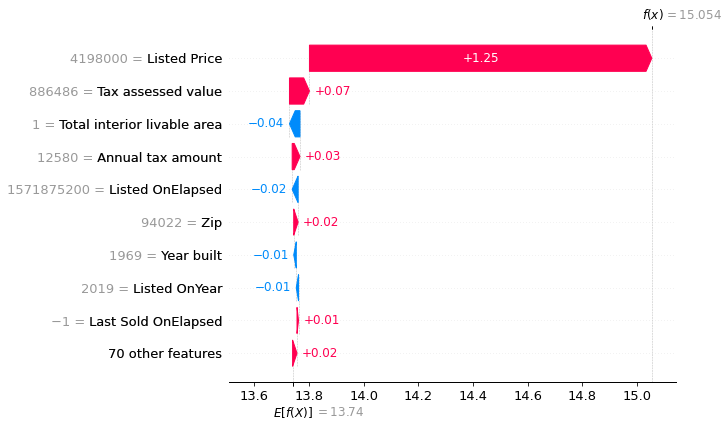

In [21]:
import shap  
shap.initjs()   

explainer = shap.TreeExplainer(modellgb)
shap_values = explainer(X_train)
shap.plots.waterfall(shap_values[0])

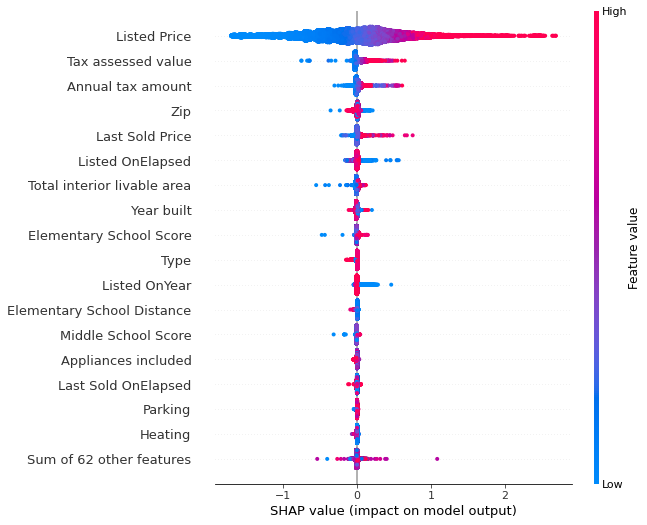

In [22]:
shap.plots.beeswarm(shap_values,max_display=18)

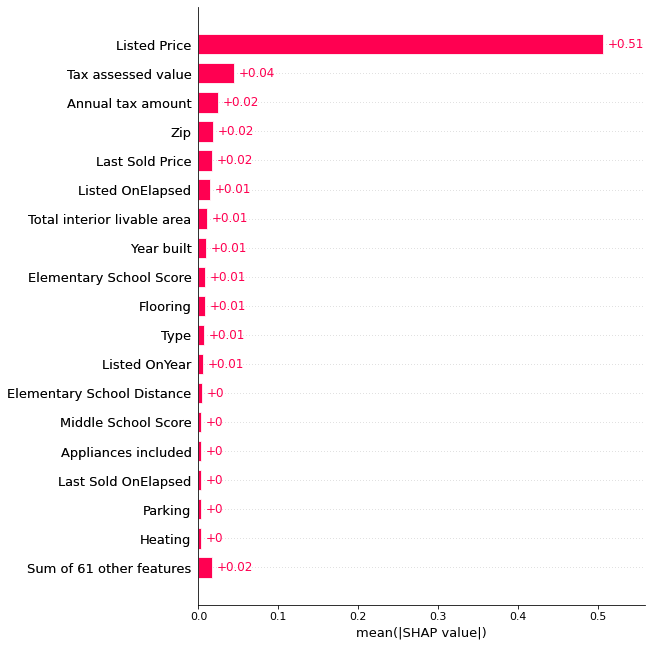

In [23]:
shap.plots.bar(shap_values,max_display=19)

In [24]:
to_keep_final=['Listed Price', 
               'Tax assessed value',
               'Annual tax amount',
               'Listed OnElapsed',
               'Last Sold Price', 
               'Zip', 
               'Parking', 
               'Year built',
               'Total interior livable area', 
               'Type',
               'Elementary School Score',
               'Listed OnYear',
               'Elementary School Distance',
               'Last Sold OnElapsed',
               'Middle School Score',
               'Lot',
               'Appliances included',
               'Listed OnDayofyear']
# to_keep_final=['Listed Price', 'Tax assessed value', 'Last Sold Price', 'Zip', 'Total interior livable area', 'Listed OnElapsed', 'Elementary School Score', 'Last Sold OnElapsed', 'Year built', 'Listed OnYear', 'High School Distance', 'Lot', 'Parking', 'Middle School Score', 'Elementary School Distance', 'Region', 'Bedrooms', 'High School Score', 'Heating', 'Appliances included', 'Flooring', 'Middle School Distance']
X_train_final = X_train[to_keep_final].copy()

In [25]:
#2nd  model train
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
lgbmodel = lgb.LGBMRegressor()

param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['auc'],
    'nthread':[4],
    "n_estimators" : np.arange(50, 300, 50),
    "learning_rate" :[0.01,0.05,0.1,0.3],
    "max_depth": np.arange(2,8,1),
    'colsample_bytree':[0.6,0.8,1],
    'lambda_l1': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    'lambda_l2': [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
    'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
    'bagging_freq': np.arange(0,81,10),
    'max_bin': np.arange(5,256,10),
    'min_data_in_leaf':np.arange(1,101,10),
    'num_leaves':np.arange(5, 100, 5),
    'min_split_gain':[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
lgbmodel = RandomizedSearchCV(estimator = lgbmodel ,
                          param_distributions = param_grid,
                          n_iter = 100,
                          verbose=1,
                          n_jobs = -1,
                          cv = 5)
lgbmodel.fit(X_train_final,y_train)
lgbmodel.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.7, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10


0.932746390043701

In [26]:
lgbmodel.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.1,
 'n_estimators': 250,
 'n_jobs': -1,
 'num_leaves': 80,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'nthread': 4,
 'min_data_in_leaf': 41,
 'metric': 'auc',
 'max_bin': 205,
 'lambda_l2': 0.7,
 'lambda_l1': 0.001,
 'feature_fraction': 0.7,
 'bagging_freq': 10,
 'bagging_fraction': 0.8}

In [27]:
best_modellgb = lgb.LGBMRegressor(boosting_type='gbdt',objective='regression',colsample_bytree=1,metrics='auc',learning_rate=lgbmodel.best_estimator_.get_params()['learning_rate'], n_estimators=lgbmodel.best_estimator_.get_params()['n_estimators'], max_depth=lgbmodel.best_estimator_.get_params()['max_depth'],num_leaves = lgbmodel.best_estimator_.get_params()['num_leaves'],max_bin = lgbmodel.best_estimator_.get_params()['max_bin'],min_child_samples=lgbmodel.best_estimator_.get_params()['min_child_samples'],min_child_weight=lgbmodel.best_estimator_.get_params()['min_child_weight'],min_split_gain=lgbmodel.best_estimator_.get_params()['min_split_gain'],min_data_in_leaf = lgbmodel.best_estimator_.get_params()['min_data_in_leaf'], bagging_fraction = lgbmodel.best_estimator_.get_params()['bagging_fraction'],feature_fraction = lgbmodel.best_estimator_.get_params()['feature_fraction'],bagging_freq=lgbmodel.best_estimator_.get_params()['bagging_freq'],lambda_l1=lgbmodel.best_estimator_.get_params()['lambda_l1'],lambda_l2=lgbmodel.best_estimator_.get_params()['lambda_l2'])
  
best_modellgb.fit(X_train_final,y_train)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=10, colsample_bytree=1,
              feature_fraction=0.7, lambda_l1=0.001, lambda_l2=0.7,
              learning_rate=0.05, max_bin=205, max_depth=6, metrics='auc',
              min_data_in_leaf=41, min_split_gain=0.1, n_estimators=250,
              num_leaves=80, objective='regression')

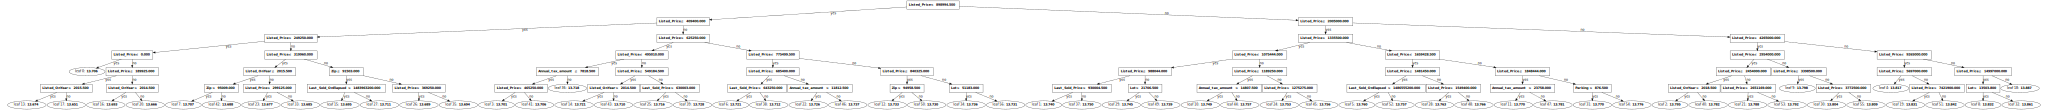

In [28]:
import graphviz 
lgb.create_tree_digraph(best_modellgb,tree_index=0,orientation='vertical')

In [29]:
X_test_num = num_pipeline.transform(df_test)
X_test_cate = cat_pipeline.transform(df_test)
X_test_date = date_pipeline.transform(df_test)
df_t = pd.concat([X_test_num, X_test_cate, X_test_date], axis=1)
df_t = df_t[to_keep_final]

In [30]:
pred=best_modellgb.predict(df_t)
df_pred=pd.DataFrame({'Id':df_test['Id'],'Sold Price': np.exp(pred)})
print(df_pred.head())
df_pred.to_csv('submission.csv', index=False)

      Id    Sold Price
0  47439  8.537137e+05
1  47440  4.808743e+05
2  47441  8.658473e+05
3  47442  8.197625e+05
4  47443  1.115973e+06
